## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### 0. Preprocess

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

cv2.destroyAllWindows()

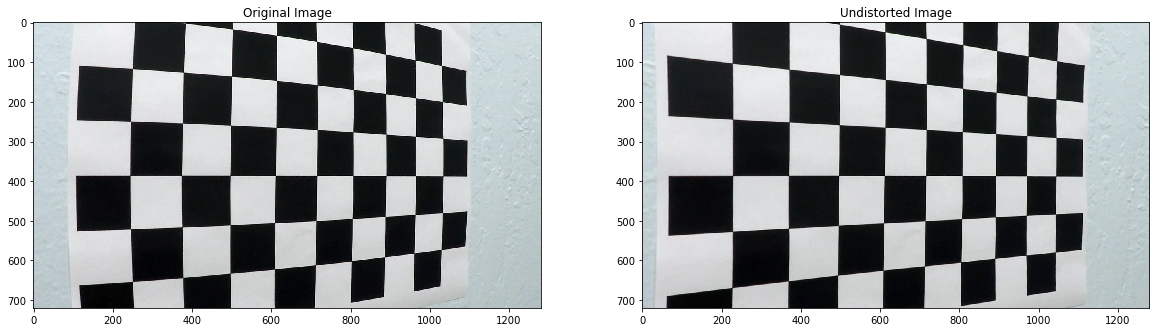

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(dst)
ax2.set_title('Undistorted Image')

### 2. Apply a distortion correction to raw images.

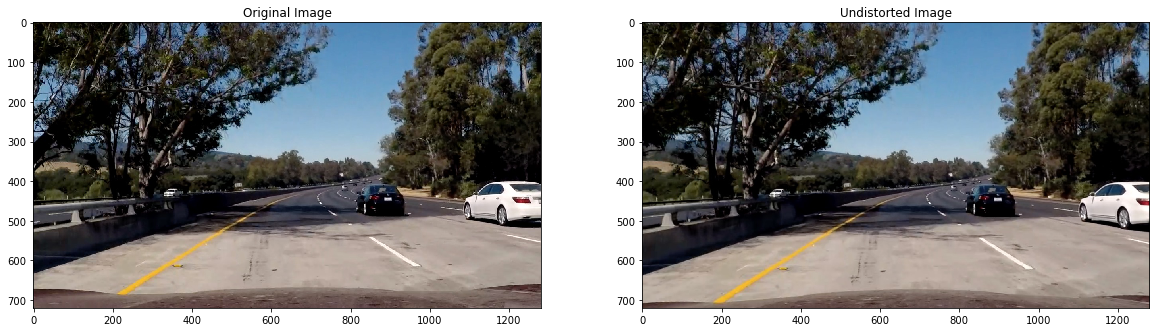

In [5]:
def distortionCorrection(origin_img):
    img_size = (origin_img.shape[1], origin_img.shape[0])
    img = cv2.undistort(origin_img, mtx, dist, None, mtx)
    return img

origin_img = cv2.imread('test_images/test5.jpg')
img = distortionCorrection(origin_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image')

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    xOrient = 1 if orient == 'x' else 0
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, xOrient, 1-xOrient, ksize=sobel_kernel))
    abs_sobel = abs_sobel * (1.0 / np.max(abs_sobel))
    sobel = np.uint8(255 * abs_sobel)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.logical_and((sobel > thresh[0]) , (sobel < thresh[1]))
    
    # 6) Return this mask as your binary_output image
    return mask

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(grad_x * grad_x + grad_y * grad_y)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    mag_abs = np.absolute(magnitude)
    mag_abs = mag_abs / np.max(mag_abs)
    mag_abs_norm = np.uint8(255 * mag_abs)
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(mag_abs_norm)
    binary_output[(mag_abs_norm >= mag_thresh[0]) & (mag_abs_norm <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(grad_x)
    abs_y = np.absolute(grad_y)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    tan_xy = np.arctan2(abs_y, abs_x)

    # 5) Create a binary mask where direction thresholds are met
    mask = np.logical_and(tan_xy > thresh[0], tan_xy < thresh[1])

    # 6) Return this mask as your binary_output image
    return mask

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = (S > thresh[0]) & (S <= thresh[1])
    
    # 3) Return a binary image of threshold result
    return binary_output * 1

In [7]:
def thresholdMask(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 100))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, thresh=(170, 255))
    grad_binary = np.zeros_like(gradx)
    grad_binary[(gradx == 1) & (grady == 1)] = 1

    threshold_binary = np.zeros_like(gradx)
    threshold_binary[ (grad_binary == 1) | (hls_binary == 1)] = 1
    
    return threshold_binary


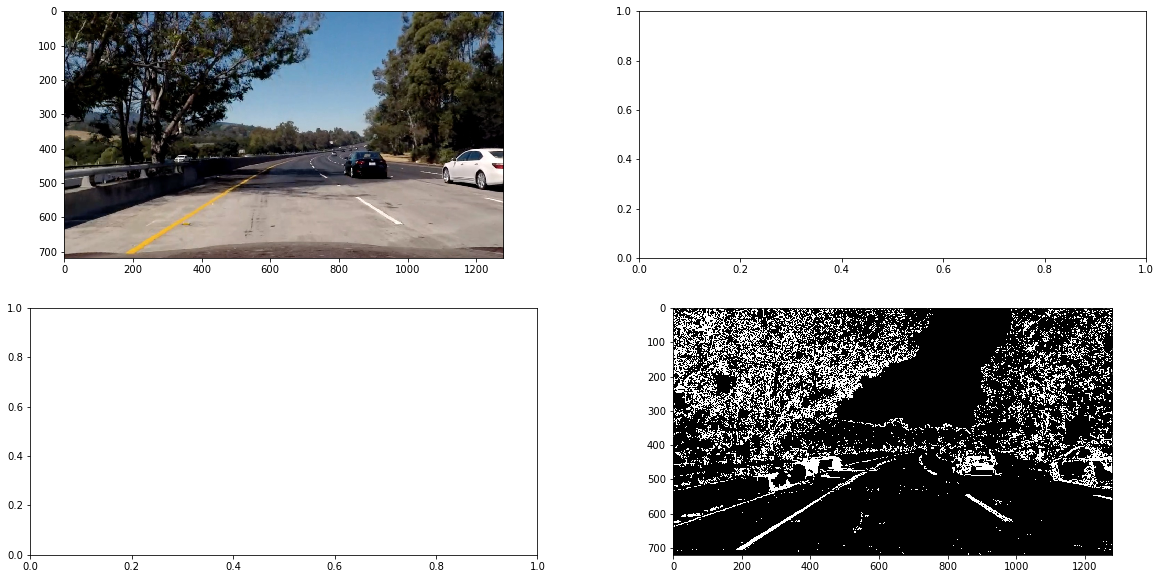

In [9]:
threshold_binary = thresholdMask(img)
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(20,10))

ax1[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# ax1[1].imshow(hls_binary, cmap = 'gray')
# ax2[0].imshow(grad_binary, cmap = 'gray')
ax2[1].imshow(threshold_binary, cmap = 'gray')

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

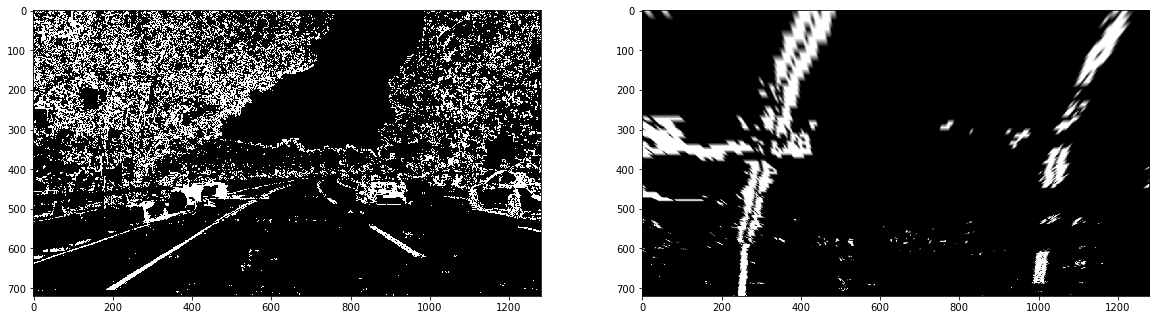

In [10]:
src = np.float32([[-80,690],[1420,690],[555,450], [730, 450]])
dst = np.float32([[0, 720], [1280, 720], [0, 0], [1280, 0]])

M = cv2.getPerspectiveTransform(src, dst)

def birdsEyeViewWarp(binImg):
    chan = binImg.astype(np.uint8) * 255
    image_to_warp = np.dstack([chan, chan, chan])
    binary_warped = cv2.warpPerspective(image_to_warp, M, (image_to_warp.shape[1], image_to_warp.shape[0]), flags=cv2.INTER_LINEAR)[:,:,0]
    return binary_warped

binary_warped = birdsEyeViewWarp(threshold_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(threshold_binary, cmap='gray')
ax2.imshow(binary_warped, cmap='gray')

### 5. Detect lane pixels and fit to find the lane boundary.

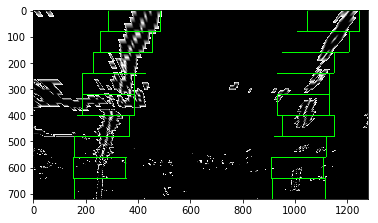

In [13]:
class LaneInfo:
    nonzerox = None
    nonzeroy = None
    left_lane_inds = None
    right_lane_inds = None
    left_curverad = 0
    right_curverad = 0
    left_fit = None
    right_fit = None
    vehicle_position = 0
    init = False

ym_per_pix = 40.0/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLane(binary_warped, laneInfo):
    if laneInfo.init == False:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        laneInfo.nonzeroy = np.array(nonzero[0])
        laneInfo.nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        laneInfo.left_lane_inds = []
        laneInfo.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((laneInfo.nonzeroy >= win_y_low) & (laneInfo.nonzeroy < win_y_high) & 
            (laneInfo.nonzerox >= win_xleft_low) &  (laneInfo.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((laneInfo.nonzeroy >= win_y_low) & (laneInfo.nonzeroy < win_y_high) & 
            (laneInfo.nonzerox >= win_xright_low) &  (laneInfo.nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            laneInfo.left_lane_inds.append(good_left_inds)
            laneInfo.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(laneInfo.nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(laneInfo.nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        laneInfo.left_lane_inds = np.concatenate(laneInfo.left_lane_inds)
        laneInfo.right_lane_inds = np.concatenate(laneInfo.right_lane_inds)
            # Extract left and right line pixel positions
        leftx = laneInfo.nonzerox[laneInfo.left_lane_inds]
        lefty = laneInfo.nonzeroy[laneInfo.left_lane_inds] 
        rightx = laneInfo.nonzerox[laneInfo.right_lane_inds]
        righty = laneInfo.nonzeroy[laneInfo.right_lane_inds] 

        laneInfo.left_fit = np.polyfit(lefty, leftx, 2)
        laneInfo.right_fit = np.polyfit(righty, rightx, 2)
    else:
        out_img = None
        nonzero = binary_warped.nonzero()
        laneInfo.nonzeroy = np.array(nonzero[0])
        laneInfo.nonzerox = np.array(nonzero[1])
        margin = 100
        laneInfo.left_lane_inds = ((laneInfo.nonzerox > (laneInfo.left_fit[0]*(laneInfo.nonzeroy**2) + laneInfo.left_fit[1]*laneInfo.nonzeroy + 
        laneInfo.left_fit[2] - margin)) & (laneInfo.nonzerox < (laneInfo.left_fit[0]*(laneInfo.nonzeroy**2) + 
        laneInfo.left_fit[1]*laneInfo.nonzeroy + laneInfo.left_fit[2] + margin))) 

        laneInfo.right_lane_inds = ((laneInfo.nonzerox > (laneInfo.right_fit[0]*(laneInfo.nonzeroy**2) + laneInfo.right_fit[1]*laneInfo.nonzeroy + 
        laneInfo.right_fit[2] - margin)) & (laneInfo.nonzerox < (laneInfo.right_fit[0]*(laneInfo.nonzeroy**2) + 
        laneInfo.right_fit[1]*laneInfo.nonzeroy + laneInfo.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = laneInfo.nonzerox[laneInfo.left_lane_inds]
        lefty = laneInfo.nonzeroy[laneInfo.left_lane_inds] 
        rightx = laneInfo.nonzerox[laneInfo.right_lane_inds]
        righty = laneInfo.nonzeroy[laneInfo.right_lane_inds]
        # Fit a second order polynomial to each
        new_left_fit = np.polyfit(lefty, leftx, 2)
        new_right_fit = np.polyfit(righty, rightx, 2)
        f = 0.8
        laneInfo.left_fit = laneInfo.left_fit * f + new_left_fit * (1-f)
        laneInfo.right_fit = laneInfo.right_fit * f + new_right_fit * (1-f)


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = 720
    laneInfo.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    laneInfo.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    laneInfo.vehicle_position = xm_per_pix * ((
        laneInfo.left_fit[0]*720**2 
        + laneInfo.left_fit[1]*720 
        + laneInfo.left_fit[2]
        + laneInfo.right_fit[0]*720**2 
        + laneInfo.right_fit[1]*720 
        + laneInfo.right_fit[2]) * 0.5 - 640)
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    laneInfo.init = True
    
    return out_img
    
info = LaneInfo()
ret = findLane(binary_warped, info)
plt.imshow(ret)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

### 7. Warp the detected lane boundaries back onto the original image.

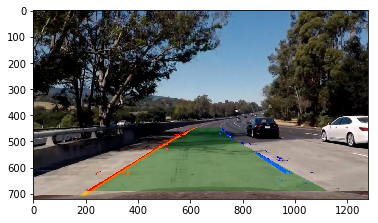

In [24]:
def overlayImg(img, laneInfo):
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.zeros_like(img)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[laneInfo.nonzeroy[laneInfo.left_lane_inds], laneInfo.nonzerox[laneInfo.left_lane_inds]] = [255, 0, 0]
    out_img[laneInfo.nonzeroy[laneInfo.right_lane_inds], laneInfo.nonzerox[laneInfo.right_lane_inds]] = [0, 0, 255]

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = laneInfo.left_fit[0]*ploty**2 + laneInfo.left_fit[1]*ploty + laneInfo.left_fit[2]
    right_fitx = laneInfo.right_fit[0]*ploty**2 + laneInfo.right_fit[1]*ploty + laneInfo.right_fit[2]
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((left_line_window, right_line_window))

    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.4, 0)
    result_warpped = cv2.warpPerspective(result, np.linalg.inv(M), (result.shape[1], result.shape[0]), flags=cv2.INTER_LINEAR)
    #result_merge = cv2.addWeighted(img[:,:,::-1], 1, result_warpped, 1, 0)
    mean_overlay = np.max(result_warpped, axis = 2) / 255.0
    overlay_mask = np.dstack([mean_overlay,mean_overlay,mean_overlay])
    result_merge = (img * (1-overlay_mask) + result_warpped * overlay_mask).astype(np.uint8)

    return result_merge
    #plt.imshow(result_merge)
    # plt.plot(np.mean(result_warpped, axis = 3, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)
    
result_merge = overlayImg(img[...,::-1], info)
plt.imshow(result_merge)

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [15]:
def addText(frame, radius, vehicle_position):
    image = Image.fromarray(frame)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("Montserrat-Light.otf", 32)
    draw.text((100, 100),"Radius: {:.2f}\nPosition: {:.2f}".format(radius, vehicle_position),(255,255,255),font=font)
    #plt.imshow(result_merge)
    return np.array(image)

In [16]:
frameLaneInfo = None

def processFrame(frame):
    frame = distortionCorrection(frame)
    canvas = thresholdMask(frame)
    canvas = birdsEyeViewWarp(canvas)
    findLane(canvas, frameLaneInfo)
    canvas = overlayImg(frame, frameLaneInfo)
    canvas = addText(canvas, 0.5*(frameLaneInfo.left_curverad + frameLaneInfo.right_curverad), frameLaneInfo.vehicle_position)
    return canvas

In [21]:
clip = VideoFileClip('challenge_video.mp4')#.subclip(1,2)
print (clip)
frameLaneInfo = LaneInfo()
out_clip = clip.fl_image(processFrame)
%time out_clip.write_videofile('output_challenge_video.mp4', audio=False)

[MoviePy] >>>> Building video output_challenge_video.mp4
[MoviePy] Writing video output_challenge_video.mp4


100%|██████████| 485/485 [02:32<00:00,  3.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video.mp4 

CPU times: user 2min 20s, sys: 48.1 s, total: 3min 8s
Wall time: 2min 34s


In [22]:
from subprocess import call
call(["say", "I am done!"])

0